# Regression spotting project

In [49]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.model_selection
from matplotlib import pyplot as plt
plt.style.use('dark_background')

from sklearn.preprocessing import StandardScaler
import umap.plot


In [50]:
# Paths:
input_dir = Path.cwd() / "../input_data"
plots_dir = Path.cwd() / "../plots"
plots_dir.mkdir(exist_ok=True)
result_dir = Path.cwd() / "../results/multioutput"
result_dir.mkdir(exist_ok=True, parents=True)

## Loading data
Loading fingerprints, and molecule properties


In [51]:
# Load fingerprints:
fingerprints = pd.read_csv(input_dir / "fingerprints.csv", index_col=0)
fingerprints.sort_index(inplace=True)
# There seems to be some duplicates in the rows:
fingerprints.drop_duplicates(inplace=True)
# Save columns names:
fingerprints_cols = fingerprints.columns

fingerprints
# fingerprints.addu

,1,8,13,26,27,31,35,41,45,62,...,1977,1991,1992,1995,2001,2004,2018,2034,2038,2044
mol_name,,,,,,,,,,,,,,,,,,,,,
2-Oxoglutaric acid,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3-Hydroxyanthranilic acid,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3-Hydroxymethylglutaric acid,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3-Phosphoglyceric acid,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"4,5-Dihydroorotic acid",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Xanthine,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
alpha-tocopherol,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
cis-Aconitic acid,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
# Load properties:
mol_properties = pd.read_csv(input_dir / "physchem_properties.csv", index_col=0)
mol_properties.sort_index(inplace=True)
mol_properties.drop_duplicates(inplace=True)
# mol_properties.set_index("name_short", inplace=True)
mol_properties_cols = mol_properties.columns
mol_properties

,pka_strongest_acidic,pka_strongest_basic,polar_surface_area,polarizability,acceptor_count,donor_count,physiological_charge
name_short,,,,,,,
2-Oxoglutaric acid,2.66,-9.70,91.67,12.17,5.0,2.0,-2.0
3-Hydroxyanthranilic acid,1.94,4.82,83.55,14.18,4.0,3.0,-1.0
3-Hydroxymethylglutaric acid,3.68,-3.00,94.83,14.55,5.0,3.0,-2.0
3-Phosphoglyceric acid,1.30,-4.20,124.29,13.29,6.0,4.0,-3.0
"4,5-Dihydroorotic acid",3.28,-8.20,95.50,13.09,4.0,3.0,-1.0
...,...,...,...,...,...,...,...
Xanthine,7.95,-0.70,86.88,12.70,3.0,3.0,0.0
alpha-tocopherol,10.80,-4.90,29.46,55.29,2.0,1.0,0.0
cis-Aconitic acid,2.11,NaN,111.90,14.16,6.0,3.0,-3.0


Check statistics of molecular properties and handle NaN values:


/var/folders/xw/tcy65hq13818_4913hhp666h0000gq/T/ipykernel_83085/1539120124.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  mol_properties.hist(ax=ax)


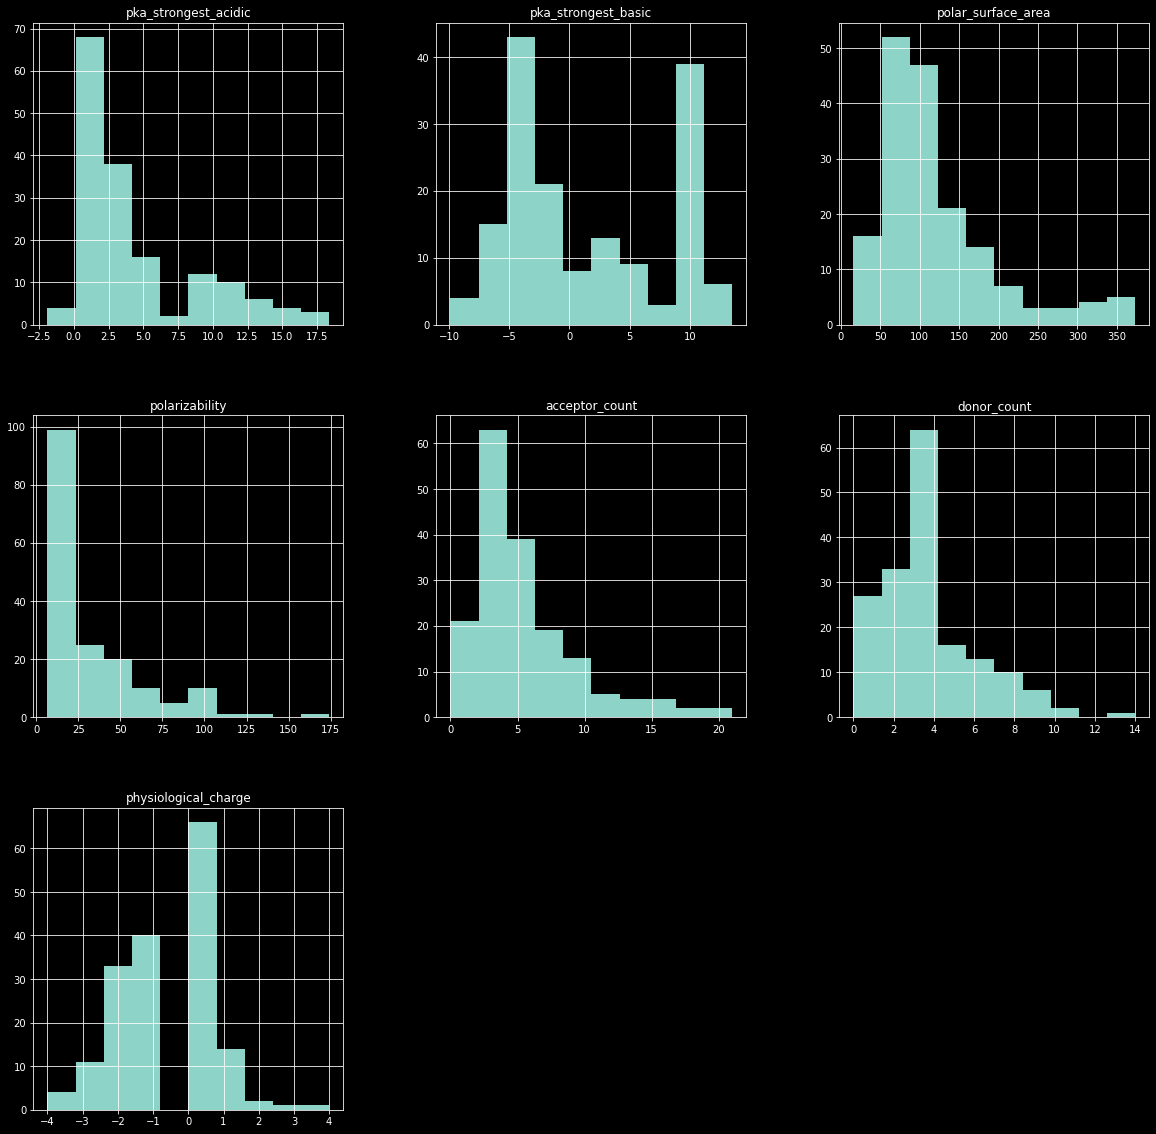

In [53]:
# Plot histograms:
fig = plt.figure(figsize = (20,20))
ax = fig.gca()
mol_properties.hist(ax=ax)
fig.savefig(plots_dir / "mol_features.pdf")

In [54]:
# Check for NaN values:
is_null = mol_properties.isnull()
for col in mol_properties_cols:
    print("---")
    print(is_null[col].value_counts())

# FIXME: temporarely set NaN to zero
mol_properties[is_null] = 0.

---
False    163
True       9
Name: pka_strongest_acidic, dtype: int64
---
False    161
True      11
Name: pka_strongest_basic, dtype: int64
---
False    172
Name: polar_surface_area, dtype: int64
---
False    172
Name: polarizability, dtype: int64
---
False    172
Name: acceptor_count, dtype: int64
---
False    172
Name: donor_count, dtype: int64
---
False    172
Name: physiological_charge, dtype: int64


In [8]:
# Perform some basic checks:
assert fingerprints.index.is_unique
assert mol_properties.index.is_unique

In [9]:
print("Number of fingerprints: ", len(fingerprints))
print("Number of mol properties: ", len(mol_properties))

print("Molecules with missing fingerprints: ")
missing_molecules = list(mol_properties[~ mol_properties.index.isin(fingerprints.index)].index)
print(missing_molecules)

# min(fingerprints.iloc[3, ] == fingerprints.iloc[4, ])


Number of fingerprints:  169
Number of mol properties:  172
Molecules with missing fingerprints: 
['Adenosine triphosphate', 'Ribose 5-phosphate', 'Spermine']


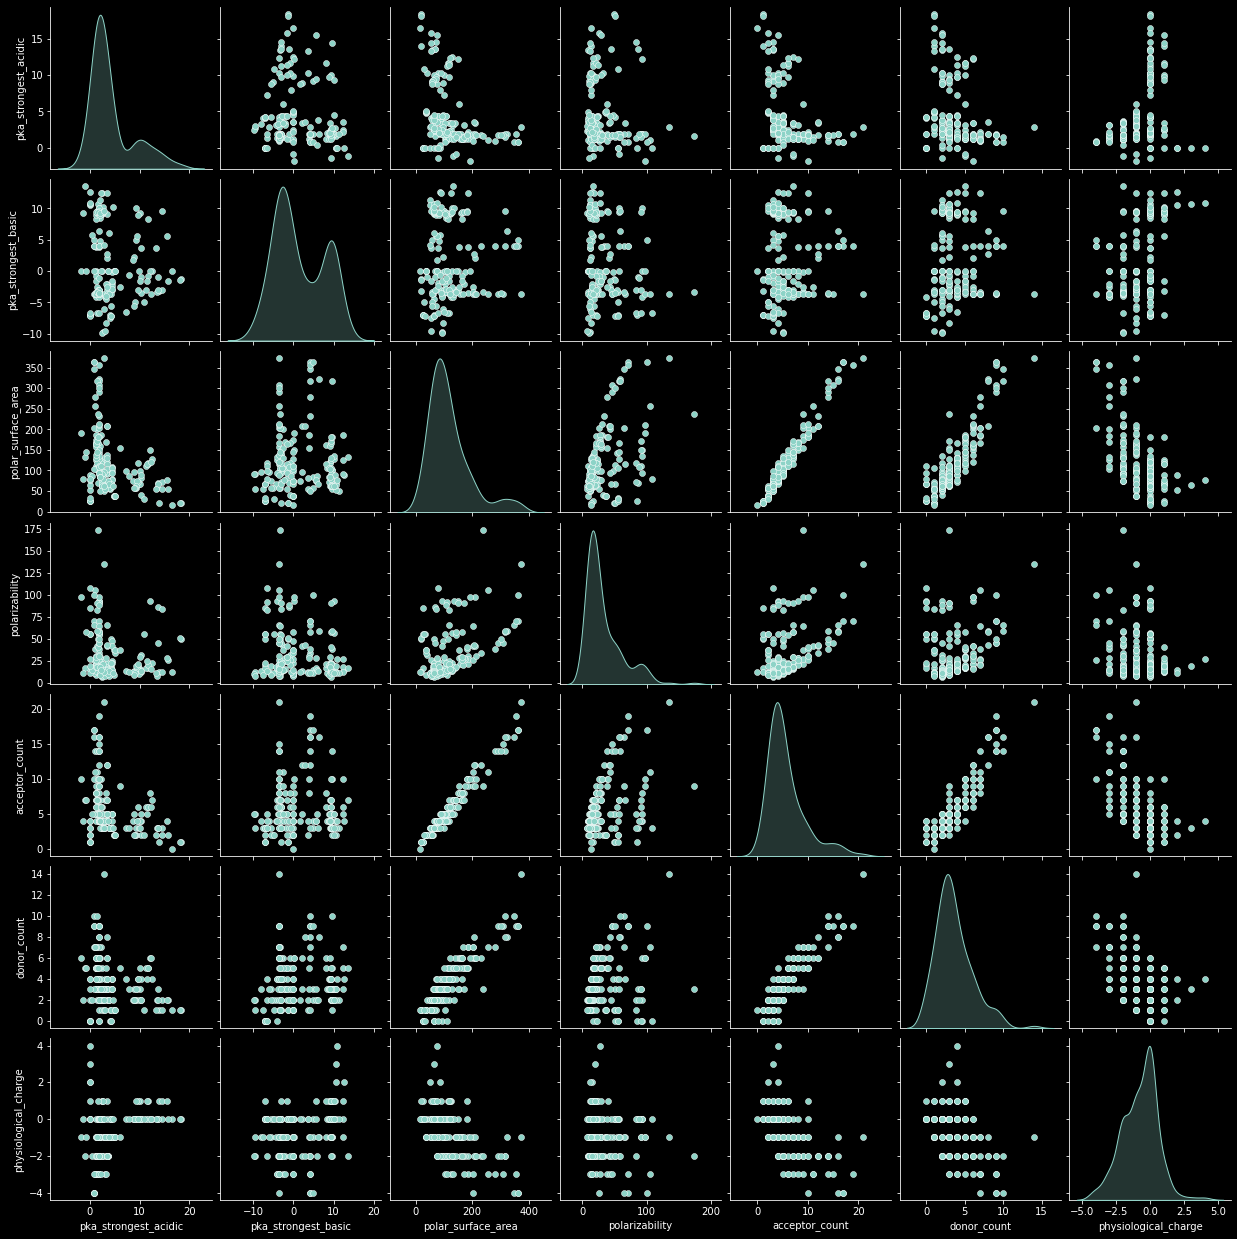

In [44]:
sns.pairplot(data=mol_properties, diag_kind='kde')

Merge fingerprints and properties:

In [10]:
all_mol_features = pd.merge(mol_properties, fingerprints, how="inner", right_index=True, left_index=True)
all_mol_features


,pka_strongest_acidic,pka_strongest_basic,polar_surface_area,polarizability,acceptor_count,donor_count,physiological_charge,1,8,13,...,1977,1991,1992,1995,2001,2004,2018,2034,2038,2044
2-Oxoglutaric acid,2.66,-9.70,91.67,12.17,5.0,2.0,-2.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3-Hydroxyanthranilic acid,1.94,4.82,83.55,14.18,4.0,3.0,-1.0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3-Hydroxymethylglutaric acid,3.68,-3.00,94.83,14.55,5.0,3.0,-2.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3-Phosphoglyceric acid,1.30,-4.20,124.29,13.29,6.0,4.0,-3.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
"4,5-Dihydroorotic acid",3.28,-8.20,95.50,13.09,4.0,3.0,-1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Xanthine,7.95,-0.70,86.88,12.70,3.0,3.0,0.0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
alpha-tocopherol,10.80,-4.90,29.46,55.29,2.0,1.0,0.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
cis-Aconitic acid,2.11,0.00,111.90,14.16,6.0,3.0,-3.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
gamma-Aminobutyric acid,4.53,10.22,63.32,10.62,3.0,2.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Loading intensities

In [55]:
# Intensities:
intensities = pd.read_csv(input_dir / "3june22_ions_no_nl.csv", index_col=0)
intensities = intensities.rename(columns={"Matrix short": "matrix", "Polarity": "polarity"})
intensities.head()

,matrix,polarity,adduct,name_short,detected,spot_intensity
0,9AA,negative,+Cl,2-Oxoglutaric acid,0,0.00000
1,9AA,negative,+Cl,3-Hydroxyanthranilic acid,1,41.60611
2,9AA,negative,+Cl,3-Hydroxymethylglutaric acid,0,0.00000
3,9AA,negative,+Cl,3-Phosphoglyceric acid,0,0.00000
4,9AA,negative,+Cl,"4,5-Dihydroorotic acid",1,160.79555


In [56]:
# Sanity checks:
nb_before = len(intensities.name_short.unique())

# Delete molecules with missing properties:
intensities = intensities[~intensities.name_short.isin(missing_molecules)]
print("{}/{} molecules kept".format(len(intensities.name_short.unique()), nb_before))



169/172 molecules kept


#### Remove molecule-adduct combinations that were never observed in any matrix

In [57]:
remove_not_detected_adducts = False

if remove_not_detected_adducts:
    g = intensities.groupby(["name_short", "adduct"], as_index=False)["detected"].max()
    nb_comb_before = intensities.shape[0]
    intensities = intensities.merge(g[g["detected"] == 1][["name_short", "adduct"]])
    print("{}/{} combinations of molecules/adduct with non-zero observed values".format(intensities.shape[0], nb_comb_before))

    # Now check if some molecules are never observed (for any adduct) and
    # remove them from the feature vectors:
    nb_mol_before = len(all_mol_features.index)
    all_mol_features = all_mol_features[all_mol_features.index.isin(intensities["name_short"].unique())]
    print("{}/{} molecules with non-zero observed values".format(len(all_mol_features.index), nb_mol_before))

#### How many molecules-adduct observed per matrix-polarity


In [58]:
g = intensities.groupby(['matrix', 'polarity'], as_index=False)
detected_ratio = g["detected"].apply(lambda x: x.sum() / x.shape[0])
detected_ratio["Sum detected"] = g["detected"].sum()["detected"]

# Show values:
detected_ratio.sort_values("detected", ascending=False).rename(columns={"detected": "Ratio detected molecules"})

,matrix,polarity,Ratio detected molecules,Sum detected
13,DHB,positive,0.322908,382
7,ClCCA,positive,0.308538,365
3,CHCA,positive,0.300085,355
11,DHAP,positive,0.232460,275
19,pNA,positive,0.231615,274
5,CMBT,positive,0.229924,272
9,DAN,positive,0.176669,209
0,9AA,negative,0.141167,167
17,NOR,positive,0.135249,160
8,DAN,negative,0.131023,155


Get statistics about adducts:


/var/folders/xw/tcy65hq13818_4913hhp666h0000gq/T/ipykernel_83085/4048890389.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  std_intesities.hist(column=["detected"], by=['matrix', "polarity"], grid=False, ax=ax)


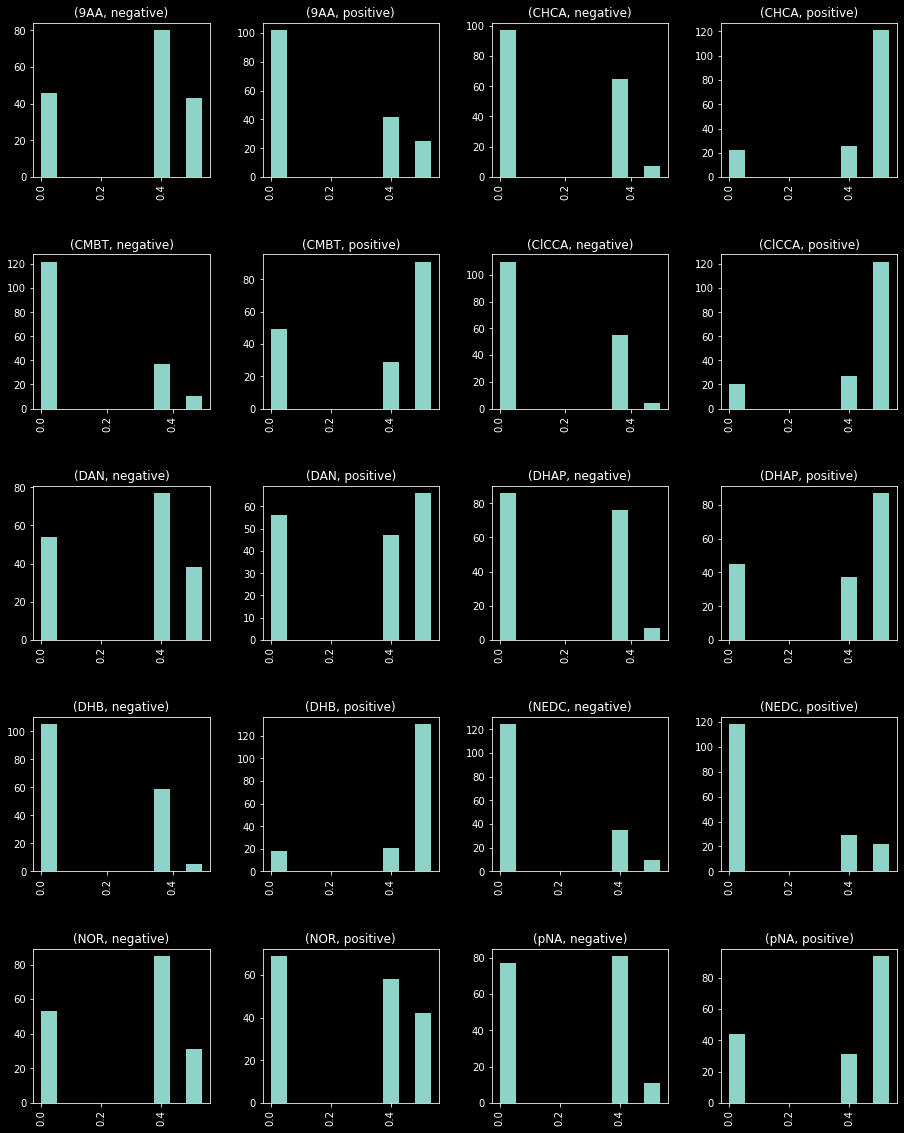

In [59]:
std_intesities = intensities.groupby(['matrix', "polarity", "name_short"], as_index=False).std()

fig = plt.figure(figsize = (15,20))
ax = fig.gca()
std_intesities.hist(column=["detected"], by=['matrix', "polarity"], grid=False, ax=ax)
fig.savefig(plots_dir / "std_detected_value.pdf")



In [60]:
# Check if entries with std=0 are always not detected:
std_intesities[std_intesities["detected"] == 0]["spot_intensity"].value_counts()

0.0    1417
Name: spot_intensity, dtype: int64

**Conclusion**: Intensities always vary across adducts (in histograms, std=0 entries were never detected for any adducts)

In [61]:
# Convert adducts to one-hot encoding:
adducts_one_hot = pd.get_dummies(intensities.adduct, prefix='adduct')
adducts_columns = adducts_one_hot.columns
intensities = intensities.merge(right=adducts_one_hot, right_index=True, left_index=True)

### How many matrices with non-zero values per molecule+adduct
Many adducts occure in several matrices, but let's see how intensities look like, ranked by higher to lower:

In [62]:
g = intensities.sort_values("spot_intensity", ascending=False).groupby(["name_short", "adduct"], as_index=False)
intensity_stats = g["detected"].sum()
for matrix_index in range(20):
    # intensity_stats["matrix_{}".format(matrix_index)] = g["spot_intensity"].max()["spot_intensity"]
    intensity_stats["matrix_{}".format(matrix_index)] = g["spot_intensity"].apply(lambda x: x.iloc[matrix_index])["spot_intensity"]
# assert intensity_stats["max"].equals(intensity_stats["max2"])
intensity_stats


,name_short,adduct,detected,matrix_0,matrix_1,matrix_2,matrix_3,matrix_4,matrix_5,matrix_6,...,matrix_10,matrix_11,matrix_12,matrix_13,matrix_14,matrix_15,matrix_16,matrix_17,matrix_18,matrix_19
0,2-Oxoglutaric acid,+Cl,0,0.000000,0.00000,0.000000,0.00000,0.000000,0.0000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2-Oxoglutaric acid,+H,0,0.000000,0.00000,0.000000,0.00000,0.000000,0.0000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2-Oxoglutaric acid,+K,1,11.875473,0.00000,0.000000,0.00000,0.000000,0.0000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2-Oxoglutaric acid,+Na,5,210.545460,79.31094,76.893745,72.43064,54.591070,0.0000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2-Oxoglutaric acid,-H,9,65207.863000,36786.18400,6752.459000,6166.86670,1492.598300,1489.3842,930.48126,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1178,myo-Inositol,+K,1,509.492550,0.00000,0.000000,0.00000,0.000000,0.0000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1179,myo-Inositol,+Na,8,4049.503000,1613.17870,1452.607400,1354.67750,772.020600,648.3625,535.32074,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1180,myo-Inositol,-H,5,1942.043300,455.85037,318.541720,130.82251,11.486426,0.0000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1181,myo-Inositol,[M]+,0,0.000000,0.00000,0.000000,0.00000,0.000000,0.0000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Intensity histograms across matrices (before normalization)
Only plot intensities > 100:

/var/folders/xw/tcy65hq13818_4913hhp666h0000gq/T/ipykernel_83085/174860316.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  _ = intensities[intensities["spot_intensity"] > 100.].hist("spot_intensity", by=["matrix", "polarity"], ax=ax, sharex=True)


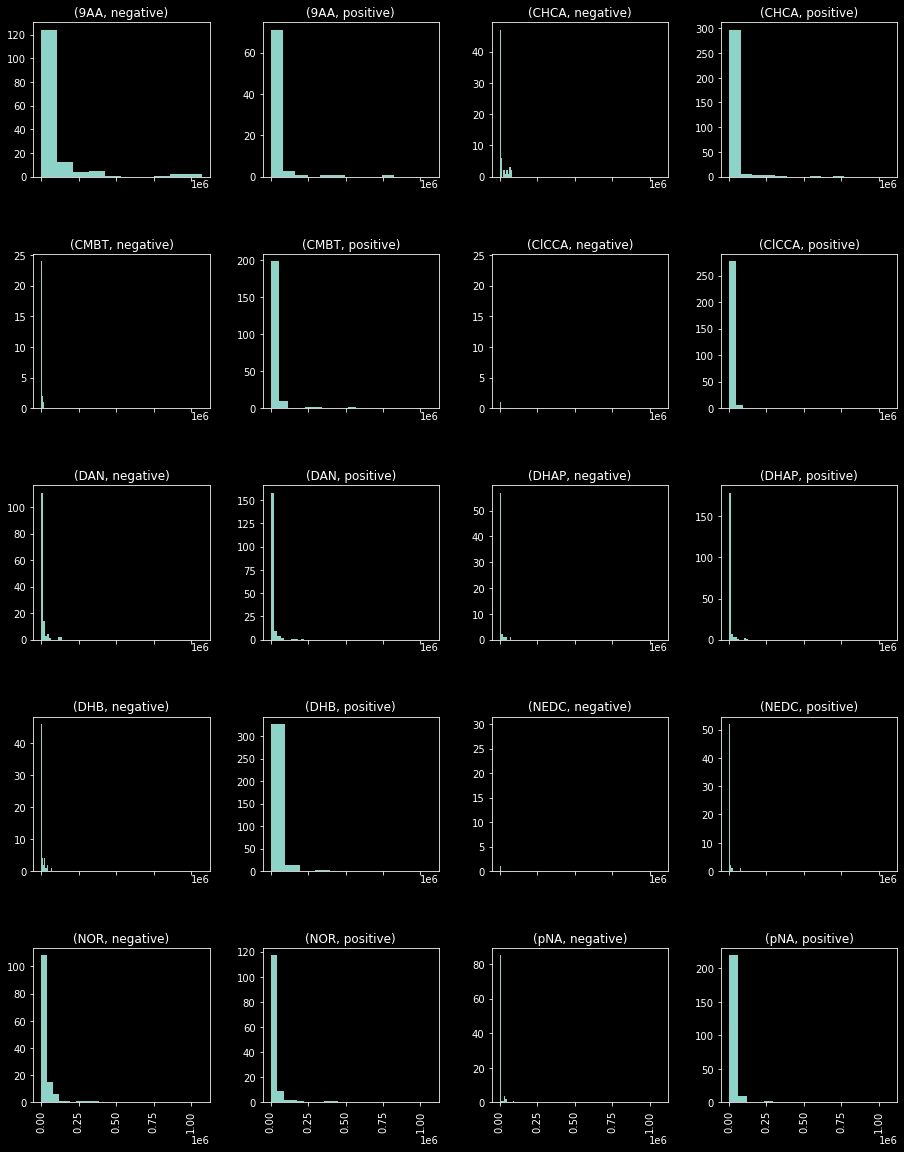

In [63]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()


_ = intensities[intensities["spot_intensity"] > 100.].hist("spot_intensity", by=["matrix", "polarity"], ax=ax, sharex=True)

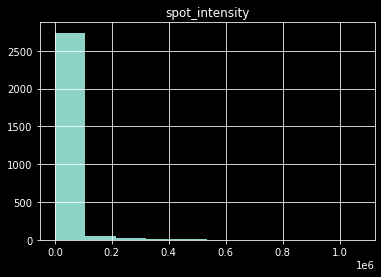

In [64]:
_ = intensities[intensities["spot_intensity"] > 100].hist("spot_intensity")

## Methods for standartization/normalization
First, normalize features

In [65]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer


ss = StandardScaler()
pt = PowerTransformer()

#OPTION 1
features_norm_df = pd.DataFrame(pt.fit_transform(all_mol_features),
                                index = all_mol_features.index,
                                columns = all_mol_features.columns)

# OPTION 2
#features_norm_df = pd.DataFrame(ss.fit_transform(all_mol_features), index = all_mol_features.index, columns = all_mol_features.columns)

# OPTION 3 (Seurat normalization)
#features_norm_df = np.log2((all_mol_features.T / all_mol_features.T.sum().values) * 10000 + 1).T


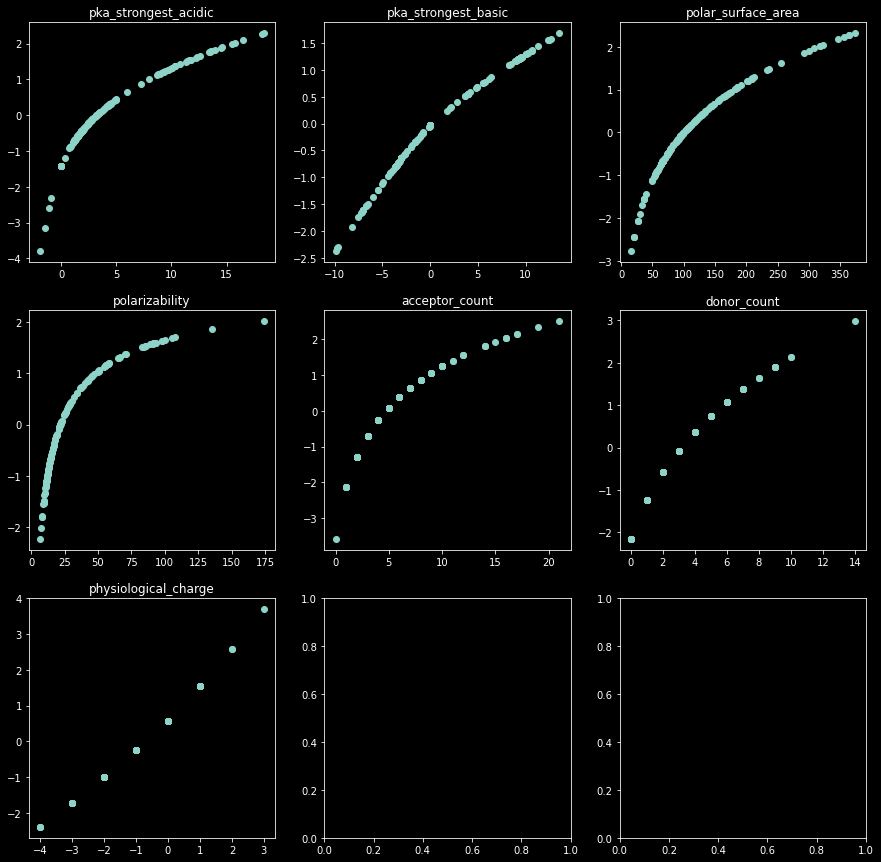

In [66]:
num_rows = 3
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
axes = [axes[i,j] for i in range(num_cols) for j in range(num_rows)]
for i, ax in enumerate(axes):
    if i < len(mol_properties_cols):
        sc = ax.scatter(all_mol_features[mol_properties_cols[i]], features_norm_df[mol_properties_cols[i]],
               # cmap = plt.cm.SOME_CM
               )
        # plt.colorbar(sc, ax=ax)
        ax.set_title(mol_properties_cols[i])
    # ax.axis('off')


#### Intensities normalization

In [67]:
intensities[intensities["spot_intensity"] < 100]["spot_intensity"] = 0

# V1 normalization:
intensities["norm_intensity"] = pt.fit_transform(intensities[["spot_intensity"]])

# V2:
numpy_intensities = intensities[["spot_intensity"]].to_numpy()
intensities["norm_intensity_seurat"] = np.log2((numpy_intensities.T / numpy_intensities.T.sum()) * 10000 + 1).T

/var/folders/xw/tcy65hq13818_4913hhp666h0000gq/T/ipykernel_83085/709589283.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intensities[intensities["spot_intensity"] < 100]["spot_intensity"] = 0


Histograms for normalization_v1: zeros values are mapped to negative values. Everything that originally had intensity < 100 is not plotted

/var/folders/xw/tcy65hq13818_4913hhp666h0000gq/T/ipykernel_83085/3936028774.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  _ = intensities[intensities["spot_intensity"] > 100].hist("norm_intensity", by=["matrix", "polarity"], ax=ax, sharex=True)


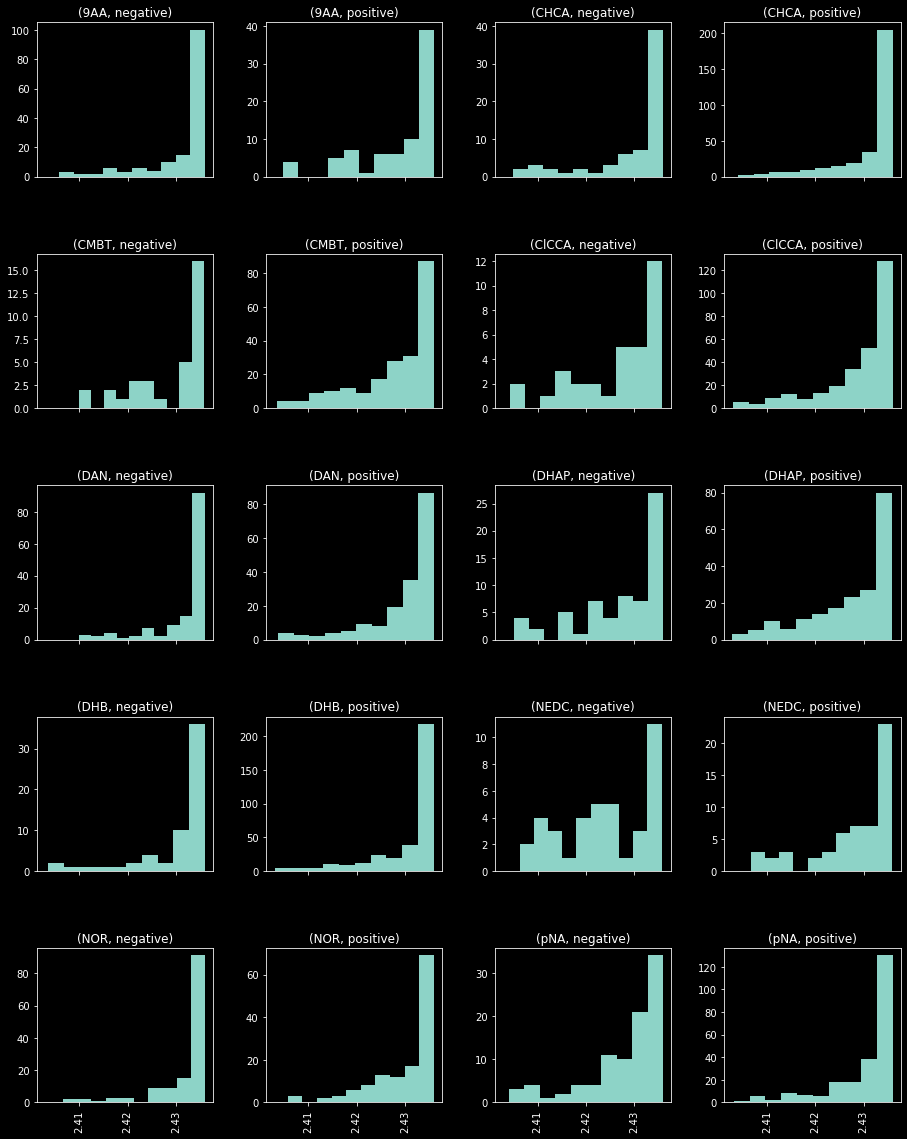

In [68]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()


_ = intensities[intensities["spot_intensity"] > 100].hist("norm_intensity", by=["matrix", "polarity"], ax=ax, sharex=True)

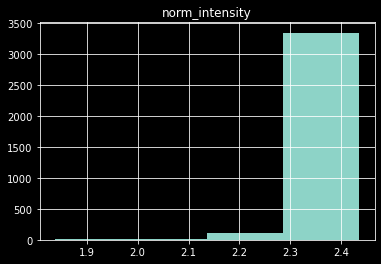

In [69]:
_ = intensities[intensities["norm_intensity"] > 0].hist("norm_intensity", bins=4)

Histograms for Seurat normalization:

/var/folders/xw/tcy65hq13818_4913hhp666h0000gq/T/ipykernel_83085/2462799206.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  _ = intensities[intensities["spot_intensity"] > 100].hist("norm_intensity_seurat", by=["matrix", "polarity"], ax=ax, sharex=True, sharey=True)


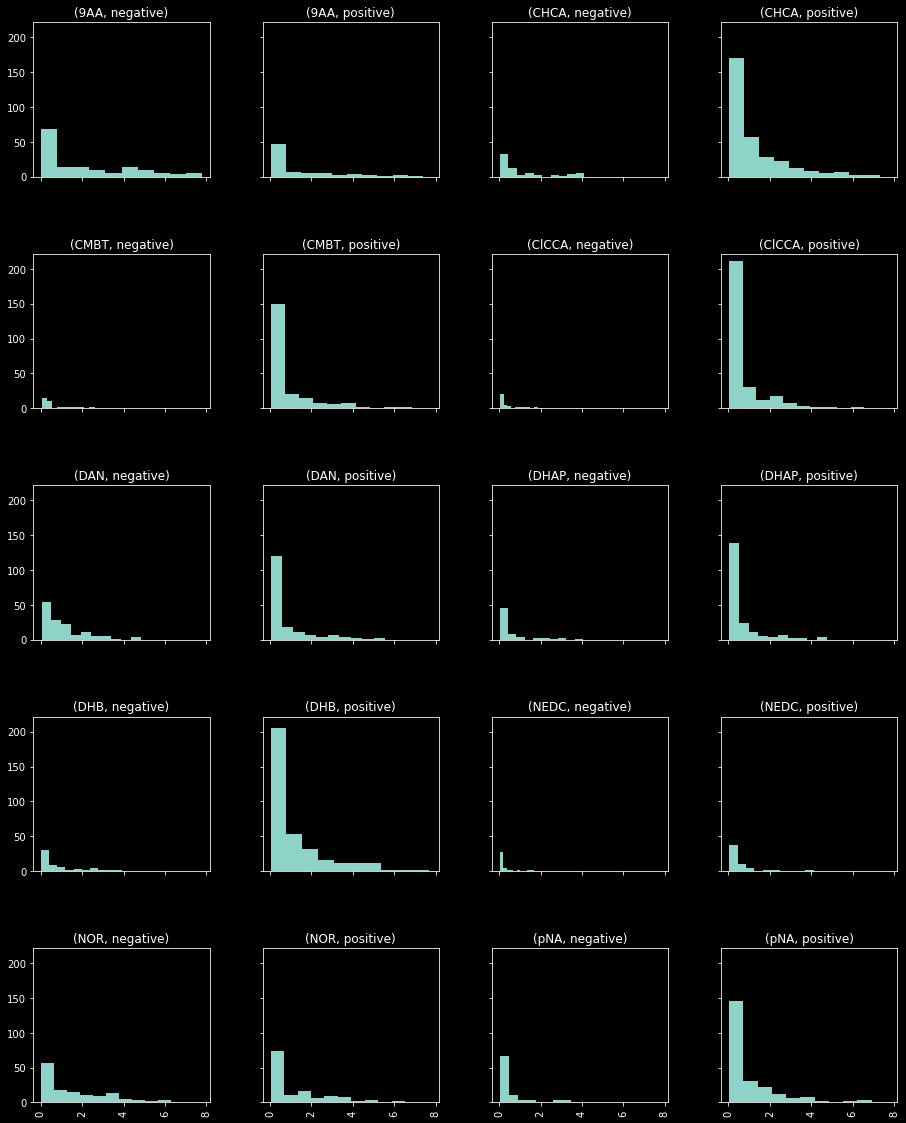

In [81]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()


_ = intensities[intensities["spot_intensity"] > 100].hist("norm_intensity_seurat", by=["matrix", "polarity"], ax=ax, sharex=True, sharey=True)

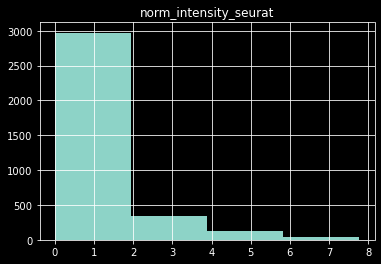

In [71]:
_ = intensities[intensities["norm_intensity_seurat"] > 0].hist("norm_intensity_seurat", bins=4)


Check how many times a matrix is the "top" matrix:

In [74]:
g = intensities.sort_values("norm_intensity_seurat", ascending=False).groupby(["name_short", "adduct"], as_index=False)
intensity_stats = g["detected"].sum()
# g.apply(lambda x: x.iloc[0])["matrix"]
intensity_stats["top_matrix"] = g.apply(lambda x: x.iloc[0])["matrix"]
intensity_stats["top_polarity"] = g.apply(lambda x: x.iloc[0])["polarity"]
for matrix_index in range(20):
    # intensity_stats["matrix_{}".format(matrix_index)] = g["norm_intensity_seurat"].max()["norm_intensity_seurat"]
    intensity_stats["matrix_{}".format(matrix_index)] = g["norm_intensity_seurat"].apply(lambda x: x.iloc[matrix_index])["norm_intensity_seurat"]
# assert intensity_stats["max"].equals(intensity_stats["max2"])
# intensity_stats


,name_short,adduct,detected,top_matrix,top_polarity,matrix_0,matrix_1,matrix_2,matrix_3,matrix_4,...,matrix_10,matrix_11,matrix_12,matrix_13,matrix_14,matrix_15,matrix_16,matrix_17,matrix_18,matrix_19
0,2-Oxoglutaric acid,+Cl,0,NEDC,negative,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2-Oxoglutaric acid,+H,0,NEDC,negative,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2-Oxoglutaric acid,+K,1,DAN,positive,0.003481,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2-Oxoglutaric acid,+Na,5,DHB,positive,0.060504,0.023090,0.022392,0.021102,0.015933,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2-Oxoglutaric acid,-H,9,9AA,negative,3.834382,3.084597,1.247078,1.172794,0.382532,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1178,myo-Inositol,+K,1,ClCCA,positive,0.142273,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1179,myo-Inositol,+Na,8,CHCA,positive,0.866916,0.409425,0.373501,0.351144,0.210447,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1180,myo-Inositol,-H,5,DAN,negative,0.480322,0.127937,0.090580,0.037891,0.003367,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1181,myo-Inositol,[M]+,0,DHB,positive,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
# Ignore never-detected ions:
intensity_stats[intensity_stats["matrix_0"] > 0][["top_matrix", "top_polarity"]].value_counts()
# pd.DataFrame().hist()


top_matrix  top_polarity
DHB         positive        176
CHCA        positive        176
9AA         negative        106
DAN         negative         59
pNA         positive         30
NOR         negative         28
ClCCA       positive         19
CMBT        positive         14
NEDC        negative          9
DAN         positive          8
DHAP        positive          7
CHCA        negative          6
NOR         positive          5
pNA         negative          5
CMBT        negative          4
DHAP        negative          4
DHB         negative          2
9AA         positive          1
NEDC        positive          1
dtype: int64

Overwrite original intensities values with normalization v1:

<AxesSubplot:xlabel='spot_intensity', ylabel='norm_intensity_seurat'>

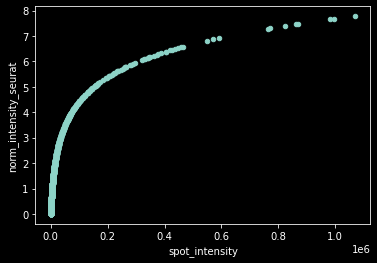

In [29]:
intensities.plot.scatter("spot_intensity", "norm_intensity_seurat")

In [30]:
intensities["spot_intensity"] = intensities["norm_intensity_seurat"]





## Data visualization in UMAP space

### UMAP based on molecule features

In [31]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(features_norm_df[mol_properties_cols])

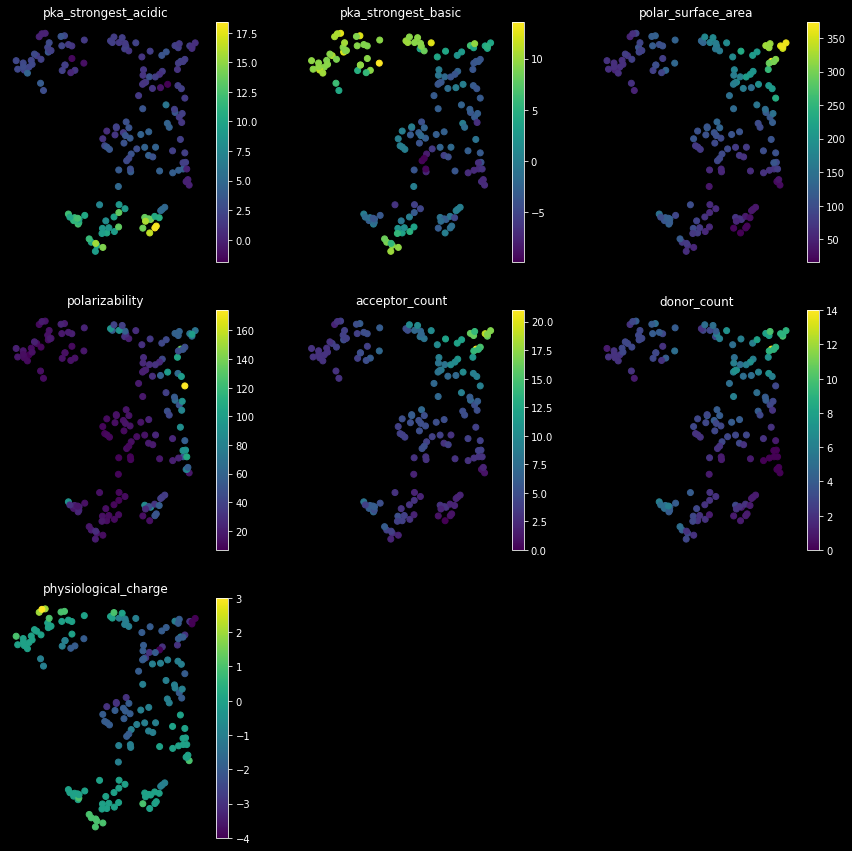

In [32]:
num_rows = 3
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
axes = [axes[i,j] for i in range(num_cols) for j in range(num_rows)]
for i, ax in enumerate(axes):
    if i < len(mol_properties_cols):
        sc = ax.scatter(embedding[:, 0], embedding[:, 1], c = all_mol_features[mol_properties_cols[i]],
               # cmap = plt.cm.SOME_CM
               )
        plt.colorbar(sc, ax=ax)
        ax.set_title(mol_properties_cols[i])
    ax.axis('off')

### UMAP based on fingerprints


In [33]:
embedding = reducer.fit_transform(features_norm_df[fingerprints_cols])

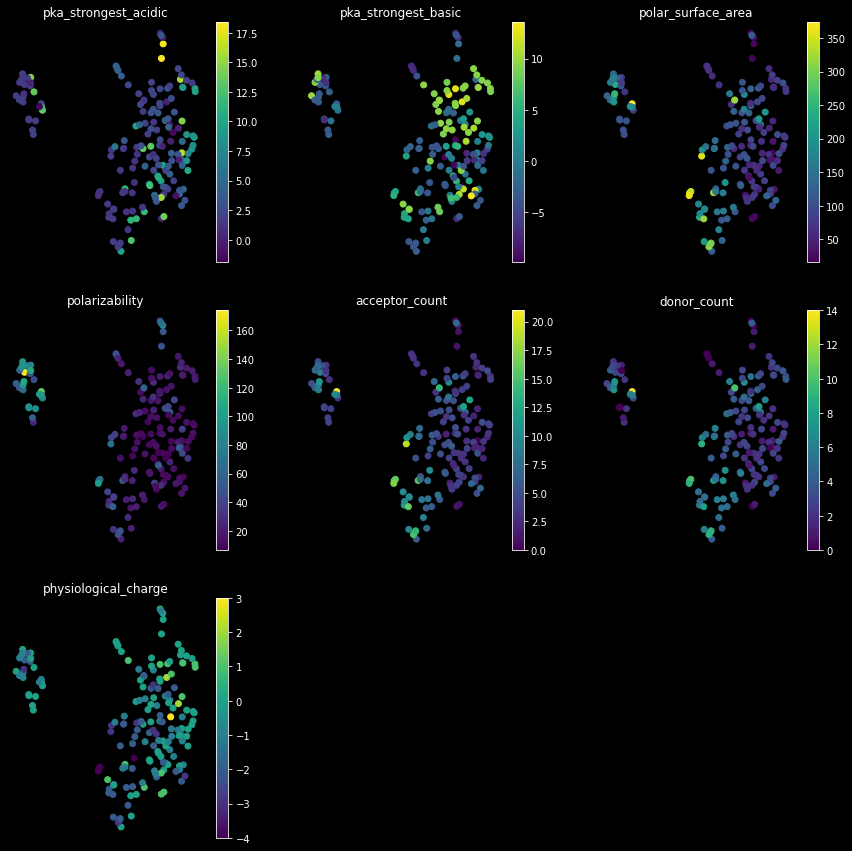

In [34]:
num_rows = 3
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
axes = [axes[i,j] for i in range(num_cols) for j in range(num_rows)]
for i, ax in enumerate(axes):
    if i < len(mol_properties_cols):
        sc = ax.scatter(embedding[:, 0], embedding[:, 1], c = all_mol_features[mol_properties_cols[i]],
               # cmap = plt.cm.SOME_CM
               )
        plt.colorbar(sc, ax=ax)
        ax.set_title(mol_properties_cols[i])
    ax.axis('off')




### UMaps showing intensity per matrix
First, try to compute UMAP on all intensities (add adducts as binary features):

In [35]:
fingerprints_plus_adducts_feat = pd.merge(intensities[adducts_columns.tolist() + ["name_short"]],
                         features_norm_df[fingerprints_cols],
                         how="left",
                         right_index=True,
                         left_on="name_short"
                         ).drop(columns=["name_short"])
embedding = reducer.fit_transform(fingerprints_plus_adducts_feat)


/Users/alberto-mac/miniconda3/envs/outerSpacem/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [36]:
# num_rows = 5
# num_cols = 4
# fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
# axes = [axes[i,j] for i in range(num_rows) for j in range(num_cols)]
#
# for i, ((matrix, polarity), rows) in enumerate(intensities.groupby(by=["matrix", "polarity"])):
#     ax = axes[i]
#     sc = ax.scatter(embedding[rows.index, 0], embedding[rows.index, 1]
#                     , c = rows["spot_intensity"], alpha=0.5
#                )
#     plt.colorbar(sc, ax=ax)
#     ax.set_title(f"{matrix}-{polarity}")
#     ax.axis('off')
#     # break
# plt.show()


## Create train/val split

First, binarize the molecule features:

/var/folders/xw/tcy65hq13818_4913hhp666h0000gq/T/ipykernel_83085/2825803642.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  features_norm_df[mol_properties_cols].hist(ax=ax)


array([[<AxesSubplot:title={'center':'pka_strongest_acidic'}>,
        <AxesSubplot:title={'center':'pka_strongest_basic'}>,
        <AxesSubplot:title={'center':'polar_surface_area'}>],
       [<AxesSubplot:title={'center':'polarizability'}>,
        <AxesSubplot:title={'center':'acceptor_count'}>,
        <AxesSubplot:title={'center':'donor_count'}>],
       [<AxesSubplot:title={'center':'physiological_charge'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

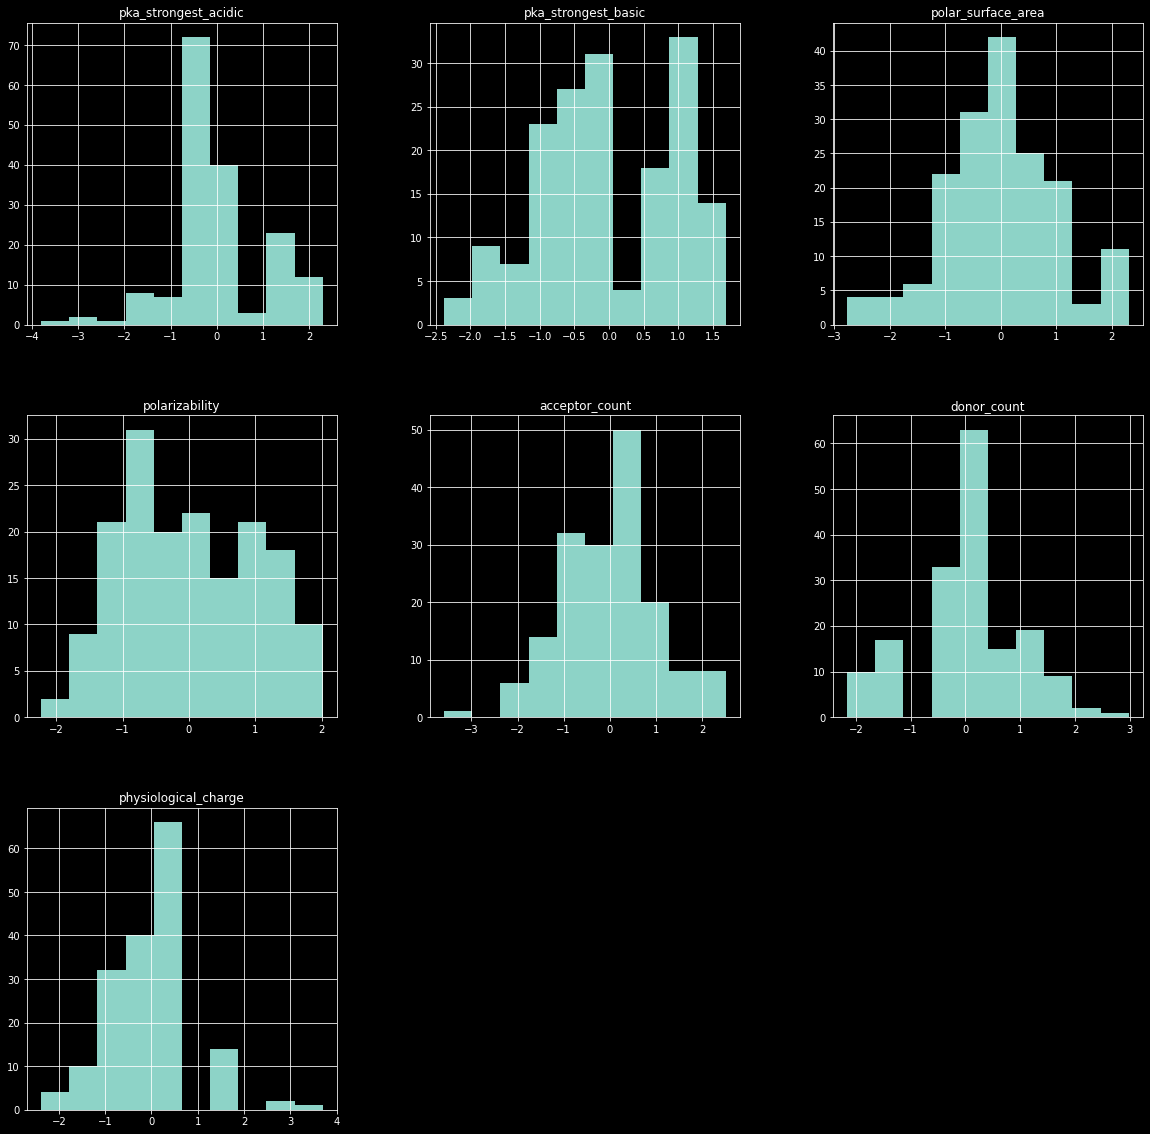

In [37]:
fig = plt.figure(figsize = (20,20))
ax = fig.gca()
features_norm_df[mol_properties_cols].hist(ax=ax)




Since not all the bins have enough datapoints, use quantiles to define the size of the bins:

In [38]:
# We only select only some features, otherwise there are not enough data in each of the splits:
# selected_stratification_features = [
#     "pka_strongest_basic",̊
#     "polar_surface_area",
#     "polarizability"
# ]
selected_stratification_features = mol_properties_cols

digitized_mol_properties = pd.DataFrame(index=features_norm_df.index)
for col in selected_stratification_features:
    digitized_mol_properties[col] = pd.qcut(features_norm_df[col], q=2, labels=[1, 2])

# digitized_mol_properties.value_counts()
# digitized_mol_properties


Now let's get the product of all the classes used for stratification:

In [39]:
intensities.columns


Index(['Matrix short', 'Polarity', 'adduct', 'name_short', 'detected',
       'spot_intensity', 'adduct_+Cl', 'adduct_+H', 'adduct_+K', 'adduct_+Na',
       'adduct_-H', 'adduct_[M]+', 'adduct_[M]-', 'norm_intensity',
       'norm_intensity_seurat'],
      dtype='object')

In [40]:
# First, remove adduct information from the intensity dataframe:
matrix_pol_df = intensities.drop(columns=['adduct', 'detected',
       'spot_intensity']).drop_duplicates().set_index('name_short', )

strat_feat = pd.merge(matrix_pol_df, digitized_mol_properties, how="left", left_index=True,
         right_index=True)
strat_feat.value_counts()

strat_feat['combined'] = strat_feat.astype(str).sum(axis=1).astype('category')

In [41]:
digitized_mol_properties['combined'] = digitized_mol_properties.astype(str).sum(axis=1).astype('category')

# digitized_mol_properties['combined'].value_counts()
